## Example

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import theano

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


### Load the data

In [2]:
# load the data from pymc3
data = pd.read_csv(pm.get_data('radon.csv'), index_col=0)

# add new column as Theano dtype
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)

# store county names and indices
county_names = data.county.unique()
county_idx = data.county_code.values
n_counties = county_names.size

In [3]:
# peek at the relevant data columns
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


### Non-hierarchical model

In [15]:
with pm.Model() as unpooled_model:

    # Independent parameters for each county
    a = pm.Normal('a', 0, sigma=100, shape=n_counties)
    b = pm.Normal('b', 0, sigma=100, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    y = pm.Normal('y', radon_est, sigma=eps, observed=data.log_radon)

In [17]:
with unpooled_model:
    unpooled_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:09<00:00, 1023.68draws/s]


### Hierarchical model

In [18]:
with pm.Model() as hierarchical_model:
    
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)
    
    # Intercept for each county, distributed around group mean mu_b
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    # Data likelihood
    radon_like = pm.Normal(
        'radon_like', 
        mu=a[county_idx] + b[county_idx] * data.floor.values,
        sigma=eps, 
        observed=data.log_radon,
    )

In [20]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(5000, tune=10000, target_accept=.95, chains=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling 8 chains, 350 divergences: 100%|██████████| 80000/80000 [03:18<00:00, 402.35draws/s]
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.821358789631422, but should be close to 0.9. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8396811307577086, but should be close to 0.9. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance 

### Plot results

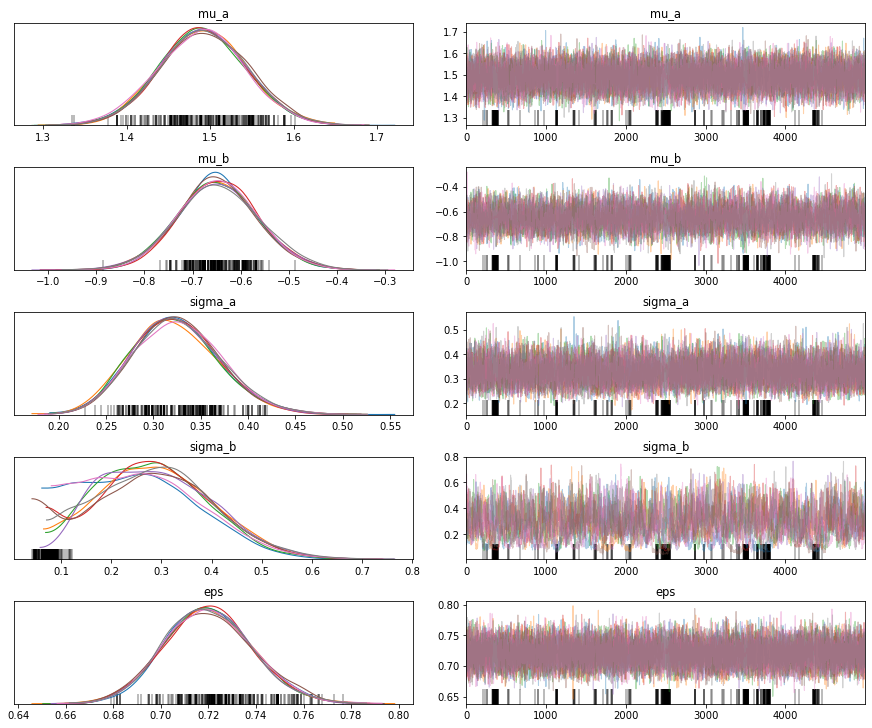

In [21]:
pm.traceplot(
    hierarchical_trace,
    var_names=[
        'mu_a', 
        'mu_b',
        'sigma_a',
        'sigma_b',
        'eps',
    ]
);

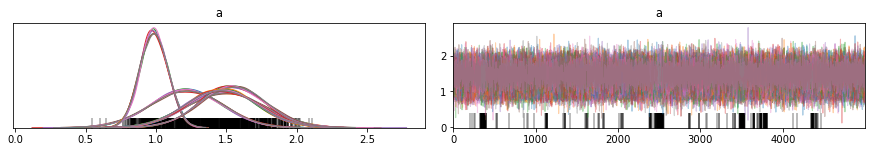

In [22]:
pm.traceplot(
    hierarchical_trace,
    var_names=['a'],
    coords={'a_dim_0': range(5)},
);

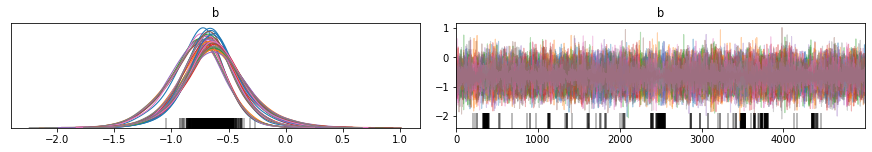

In [26]:
pm.traceplot(
    hierarchical_trace,
    var_names=['b'],
    coords={'b_dim_0': range(5)},
);